In [1]:
import os
import time 
import numpy as np 
import torch
import torch.optim as optim
import random
from torch.utils import data
from loader.COSMOS_data_loader import COSMOS_data_loader
from models.unet import Unet
from models.VAE import VAE
from utils.train import *
from utils.medi import *
from utils.data import *
from utils.files import *

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rootDir = '/data/Jinwei/Bayesian_QSM/weight'

In [3]:
# patchSize = (64, 64, 32)
patchSize = (128, 128, 32)
extraction_step = (42, 42, 6)
voxel_size = (1, 1, 3)
latent_dim = 60
flag_smv = 1
flag_gen = 1
trans = 0.4  # 0.15 for PDI
scale = 3

In [4]:
dataLoader = COSMOS_data_loader(
    split='Val',
    patchSize=patchSize,
    extraction_step=extraction_step,
    voxel_size=voxel_size,
    case_validation=6,
    case_test=7,
    flag_smv=flag_smv,
    flag_gen=flag_gen
)

Using SMV Filtering
Generate RDF from COSMOS data
Processing case: 6
    Direction: 0
    Direction: 1
    Direction: 2
    Direction: 3
    Direction: 4
360 Val cases in total


In [5]:
testLoader = data.DataLoader(dataLoader, batch_size=16, shuffle=False)

In [6]:
vae3d = VAE(
    input_channels=1, 
    output_channels=2,
    latent_dim=2000,
    use_deconv=1,
    renorm=1,
    flag_r_train=0
)
vae3d.to(device)
print(vae3d)
vae3d.load_state_dict(torch.load('/data/Jinwei/Bayesian_QSM/weight_cv/weights_vae=-2_validation=6_test=7.pt'))

VAE(
  (path_encoder): ModuleList(
    (0): Sequential(
      (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (1): Sequential(
      (0): LeakyReLU(negative_slope=0.01, inplace=True)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (2): Sequential(
      (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (3): Sequential(
      (0): LeakyReLU(negative_slope=0.01, inplace=True)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv3d(64, 64, ke

<All keys matched successfully>

In [7]:
# patches_means, patches_stds = [], []
qsm_min = 0
vae3d.eval()
with torch.no_grad():
    for idx, (rdfs, masks_tensor, weights, qsms_tensor) in enumerate(testLoader):
        print(idx)
        if idx == 6:
            break
        idx += 1
        qsms = (qsms_tensor.to(device, dtype=torch.float) + trans) * scale
        masks = masks_tensor.to(device, dtype=torch.float)
        qsms = qsms * masks
        x_mu, x_var, z_mu, z_logvar = vae3d(qsms)
        
        print(x_mu.mean())
    
#     qsms = np.asarray(qsms.cpu().detach())
#     if qsms.min()/3 - 0.15 < qsm_min:
#         qsm_min = qsms.min()
    
#     means = np.asarray(means.cpu().detach())
#     stds = np.asarray(stds.cpu().detach())
    
#     patches_means.append(means)
#     patches_stds.append(stds)
    
# patches_means = np.concatenate(patches_means, axis=0)
# patches_stds = np.concatenate(patches_stds, axis=0)

0
tensor(0.4130, device='cuda:0')
1
tensor(0.5153, device='cuda:0')
2
tensor(0.5173, device='cuda:0')
3
tensor(0.4082, device='cuda:0')
4
tensor(0.5178, device='cuda:0')
5
tensor(0.4984, device='cuda:0')
6


In [8]:
qsms = np.asarray(qsms.cpu().detach())
masks = np.asarray(masks.cpu().detach())
x_mu = np.asarray(x_mu.cpu().detach())
x_var = np.asarray(x_var.cpu().detach())

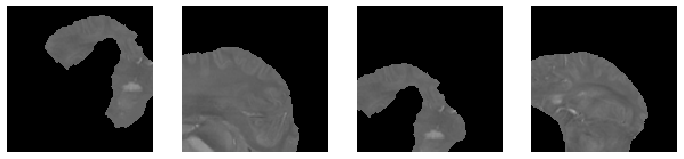

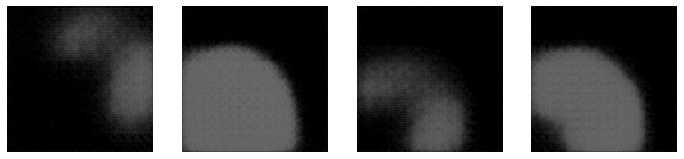

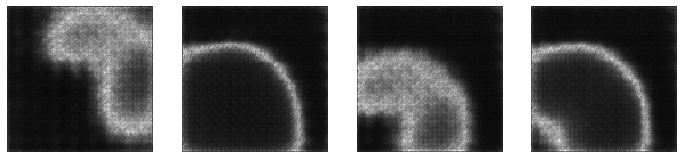

In [10]:
# plot
slice_idx = 10
idx_plot = np.random.choice(qsms.shape[0], size=(4, ), replace=False)
plots(qsms[:, 0, ..., slice_idx][idx_plot, ...], rows=1, scale=(0, 3))
plots(x_mu[:, 0, ..., slice_idx][idx_plot, ...], rows=1, scale=(0, 3))
plots(x_var[:, 0, ..., slice_idx][idx_plot, ...], rows=1, scale=(1e-6, 5e-5))

In [ ]:
qsms.min()

In [ ]:
x_mu.shape

In [ ]:
QSM = reconstruct_patches(patches_means, dataLoader.volSize, extraction_step)
STD = reconstruct_patches(patches_stds, dataLoader.volSize, extraction_step)

In [ ]:
adict = {}
adict['QSM'] = QSM
sio.savemat('QSM.mat', adict)

adict = {}
adict['STD'] = STD
sio.savemat('STD.mat', adict)